In [109]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

from catboost import CatBoostClassifier

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from hyperopt import fmin, tpe, hp, STATUS_OK, rand, Trials
from hyperopt.plotting import main_plot_history

import modelplotpy as mp 

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('./train.csv')
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

### EDA

In [3]:
train_data.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0


In [4]:
train_data.shape

(5282, 20)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

### Analysis of numeric columns

In [7]:
train_data = train_data.mask(train_data == ' ')

In [8]:
train_data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [9]:
train_data[train_data['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [10]:
train_data.loc[train_data['TotalSpent'].isna(),'TotalSpent'] = train_data['MonthlySpending']
train_data['TotalSpent'] = train_data['TotalSpent'].astype('float64')

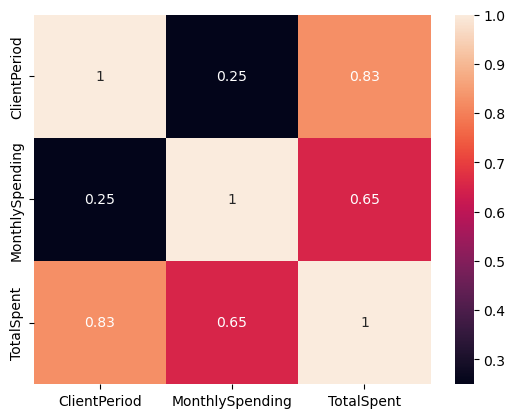

In [11]:
sns.heatmap(train_data[num_cols].corr(), annot=True);

In [12]:
train_data[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.564824
std,24.550326,30.176464,2268.970866
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


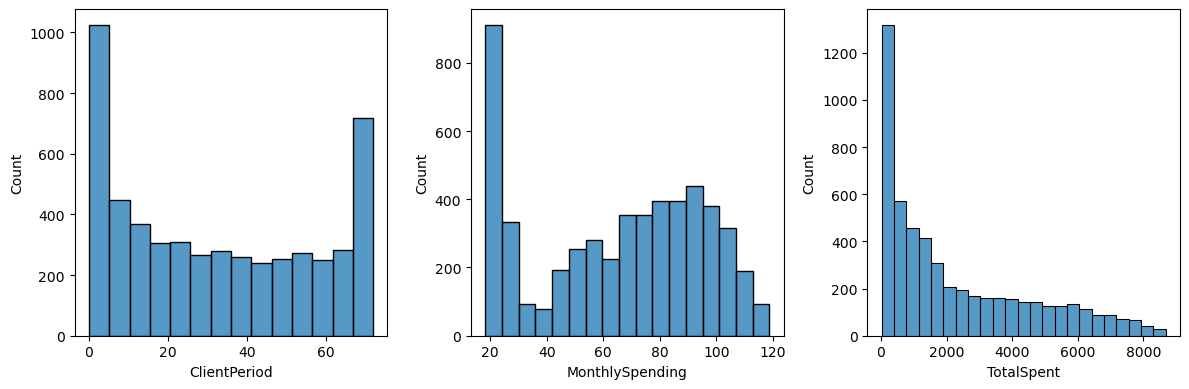

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))  

for col, subplots in zip (num_cols, ax.flatten()):  
    sns.histplot(data=train_data, x=col, ax=subplots)
    
fig.tight_layout()
plt.show()

### Analysis of categorical columns

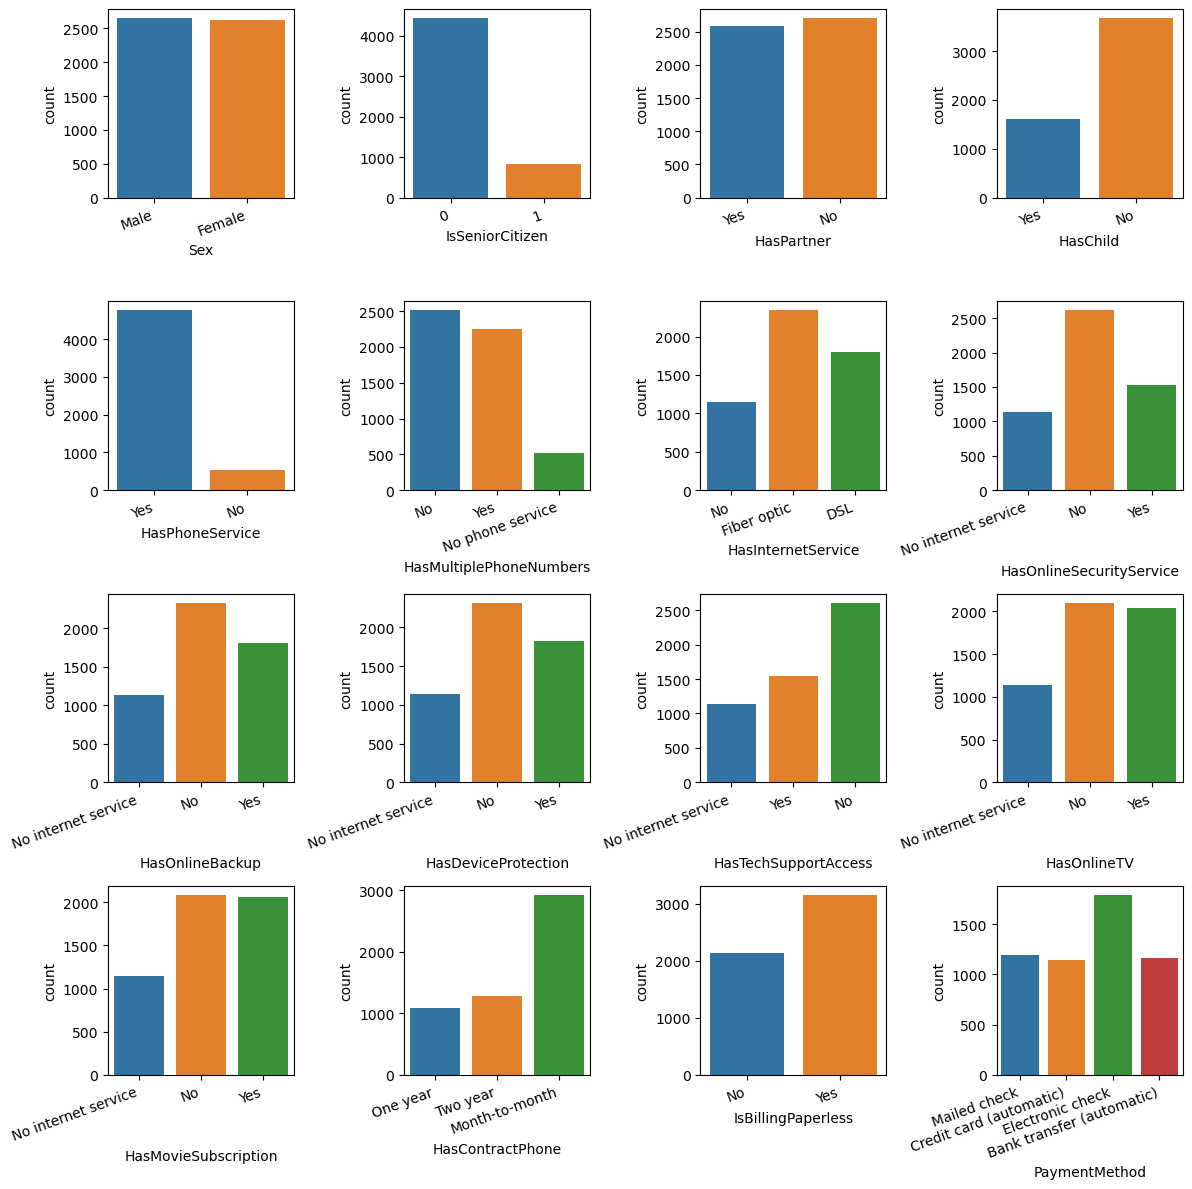

In [14]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))  

for col, subplots in zip (cat_cols, ax.flatten()):  
    plot = sns.countplot(train_data, x=col, ax=subplots)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=20,
                        horizontalalignment='right')
    
fig.tight_layout()
plt.show()

### Analysis of target column

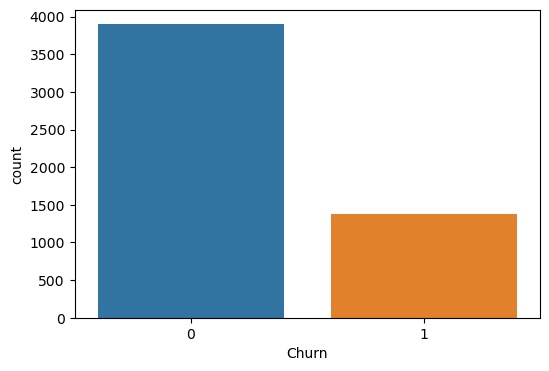

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(train_data, x=target_col);

In [16]:
train_data[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

### Logistic Regression - baseline

In [17]:
X, y = train_data[feature_cols], train_data[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
len(y_train), len(y_val)

(4225, 1057)

In [19]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True)

(0    0.738225
 1    0.261775
 Name: Churn, dtype: float64,
 0    0.736991
 1    0.263009
 Name: Churn, dtype: float64)

In [20]:
columnTransformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])

In [21]:
clf = make_pipeline(columnTransformer, LogisticRegression())
clf.fit(X_train, y_train)
y_scores = clf.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_scores)

0.8287649726175415

### Optimizing Logistic Regression

In [110]:
def objective(trial):
    params_common = {
        'logisticregression__C': trial.suggest_float('C', 0.01, 100),
        'logisticregression__max_iter': 1000,
        'logisticregression__random_state': 42
    }
    
    regressor_name = trial.suggest_categorical('classifier', ['logreg_l1', 'logreg_l2', 'logreg_elasticnet'])
    if regressor_name == 'logreg_l1':
        params = {
            **params_common,
            'logisticregression__solver': trial.suggest_categorical('l1_solver', ['liblinear', 'saga'])
        }
    elif regressor_name == 'logreg_l2':
        params = {
            **params_common,
            'logisticregression__solver': trial.suggest_categorical('l2_solver', ['lbfgs', 'liblinear', 'newton-cg', 
                                                                               'newton-cholesky', 'sag', 'saga'])
        }
    else: 
        params = {
            **params_common,
            'logisticregression__l1_ratio': trial.suggest_float('l1_ratio', 0.01, 0.99),
            'logisticregression__solver': 'saga'
        }

    clf.set_params(**params)
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_scores)

In [111]:
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=200, show_progress_bar=True) 

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
best_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

  0%|          | 0/200 [00:00<?, ?it/s]

Number of finished trials:  200
Best trial:
  Value: 0.8290374119189885
  Params: 
    C: 0.324210099265753
    classifier: logreg_l1
    l1_solver: liblinear


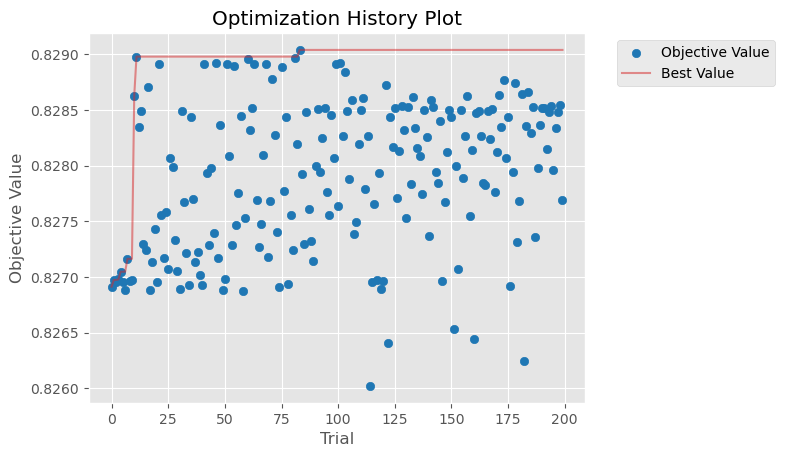

In [112]:
optuna.visualization.matplotlib.plot_optimization_history(study);

### Catboost

In [25]:
catb = CatBoostClassifier()
catb.fit(X_train, y_train, cat_features=cat_cols, verbose=False)
y_scores = catb.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_scores)

0.8220578864251347

### Optimizing Catboost

In [26]:
def hyperopt_catboost(X_train, y_train, X_val, y_val, params_space, plot_optimization_history=True):

    def objective(params):
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train)
        score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        
        y_val_pred = model.predict_proba(X_val)[:, 1]
        score_val = roc_auc_score(y_val, y_val_pred)
        score_val = 1 - score_val

        return {"loss": score_val, "score_train": score_train, "model": model, "status": STATUS_OK}

    trials = Trials()
    
    best_params = fmin(
        objective,
        space=params_space,
        algo=tpe.suggest,
        max_evals=200,
        trials=trials
    )
    
    best_metrics = sorted(trials._dynamic_trials, key=lambda x: x["result"]["loss"])[0]["result"]

    current_val_score = 1 - best_metrics["loss"]
    history = {
        "best_params": best_params,
        "roc_auc_val": current_val_score,
        "roc_auc_val_train": best_metrics["score_train"],
        "model": best_metrics["model"],
    }
    
    if plot_optimization_history:
        main_plot_history(trials)
    
    return (
        best_metrics["model"],
        current_val_score,
        history
    )

In [64]:
params_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-3), np.log(1e-1)),
    'depth': hp.quniform('depth', 3, 6, 1),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bylevel': hp.quniform('colsample_bylevel', 0.1, 1, 0.1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 100, 1),
    'cat_features': cat_cols,
    'random_seed': 42,
    'verbose': False
}

100%|█| 200/200 [07:41<00:00,  2.31s/trial, best loss: 0.16578624135
avg best error: 0.16578624135351538


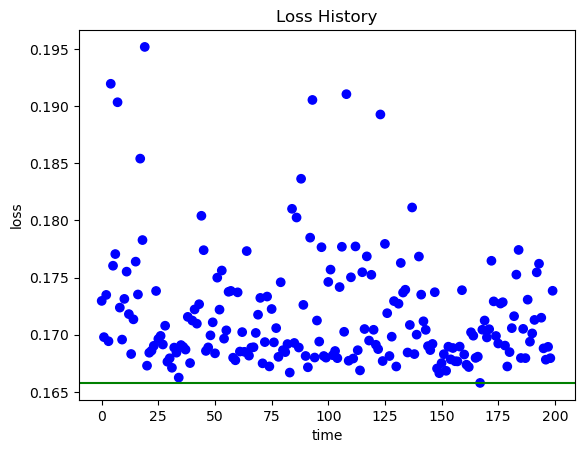

(<catboost.core.CatBoostClassifier at 0x7faa65a75f00>,
 0.8342137586464846,
 {'best_params': {'colsample_bylevel': 0.1,
   'depth': 3.0,
   'learning_rate': 0.02570312542761379,
   'min_data_in_leaf': 74.0,
   'subsample': 0.1},
  'roc_auc_val': 0.8342137586464846,
  'roc_auc_val_train': 0.8634063115467412,
  'model': <catboost.core.CatBoostClassifier at 0x7faa65a75f00>})

In [65]:
catboost_optimized = hyperopt_catboost(X_train, y_train, X_val, y_val, params_space)
catboost_optimized

In [66]:
obj = mp.modelplotpy(
    feature_data = [X_train, X_val],
    label_data = [y_train, y_val],
    dataset_labels = ['train data', 'test data'],
    models = [clf, catboost_optimized[0]],
    model_labels = ['clf', 'catboost']
)

# ps = obj.plotting_scope(select_model_label = ['catboost'], select_dataset_label = ['test data'])
ps = obj.plotting_scope(scope = "compare_models", select_dataset_label=['test data'])

compare models
The label with smallest class is [1]


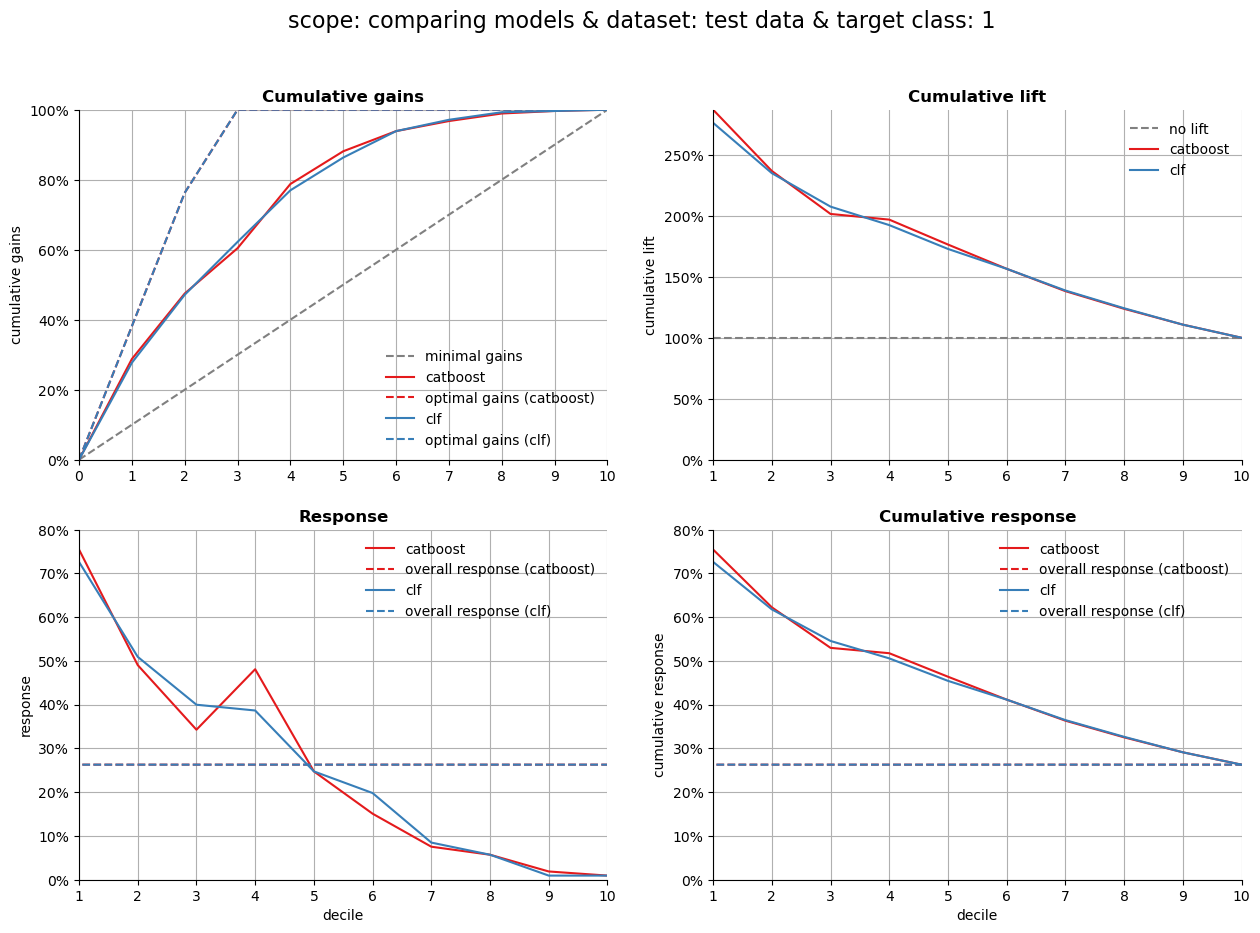

<Axes: title={'center': 'Cumulative gains'}, ylabel='cumulative gains'>

In [67]:
mp.plot_all(ps, save_fig=False)

In [68]:
costs = {
    'FP': 100,
    'FN': 1000,
    'TP': -500,
    'TN': 0
}

In [69]:
probs = catboost_optimized[0].predict_proba(X_val)[:, 1]

In [70]:
preds = np.where(probs >= 0.5, 1., 0.)

In [71]:
np.argsort(-probs)

array([514, 974, 552, ...,  11, 513, 658])

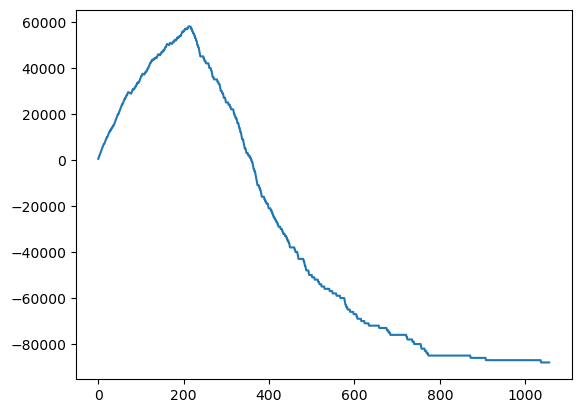

In [72]:
from sklearn.metrics import confusion_matrix
res = []
for idx in np.argsort(-probs):
    tn, fp, fn, tp = confusion_matrix([y_val.values[idx]], [preds[idx]], labels=[0, 1]).ravel()
    if tn:
        res.append(costs['TN'])
    elif fp:
        res.append(costs['FP'])
    elif fn:
        res.append(costs['FN'])
    else:
        res.append(costs['TP'])

        
plt.plot(np.cumsum(-np.array(res)))

In [31]:
X_test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

submission['Churn'] = catboost_optimized[0].predict_proba(X_test)[:, 1]
submission.to_csv('my_submission.csv')